1. 데이터셋 불러오기
2. 변수 중요도 -> 변수 선택
3. 스케일링 / 차원축소 등 -> 전처리
4. 엘보 method -> 최적 군집 개수 파악
5. 군집화 -> 실루엣 계수 / 시각화하여 군집 잘 되었는지 확인

6. 군집별 마케팅 제언

In [ ]:
# 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 한글 font 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='NanumBarunGothic')
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
plt.rcParams['axes.unicode_minus'] = False

# <font color='red'>__데이터셋__</fonc>

In [ ]:
%cd /content/drive/MyDrive/1.ldata_현정

/content/drive/MyDrive/1.ldata_현정


In [ ]:
# 데이터셋 불러오기
dataset1 = pd.read_csv('test/dataset1_test.csv',index_col=0)
dataset2 = pd.read_csv('test/dataset2_test.csv',index_col=0)

In [ ]:
# 상관계수 확인
plt.figure(figsize=(15,15))
sns.heatmap(dataset1.corr(), annot=True)

In [ ]:
# 데이터 분리
from sklearn.model_selection import train_test_split

X = dataset1.drop('y', axis=1)
y = dataset1['y']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.3,
                                                   random_state=1004)

# 변수 중요도

정확도 : 0.71


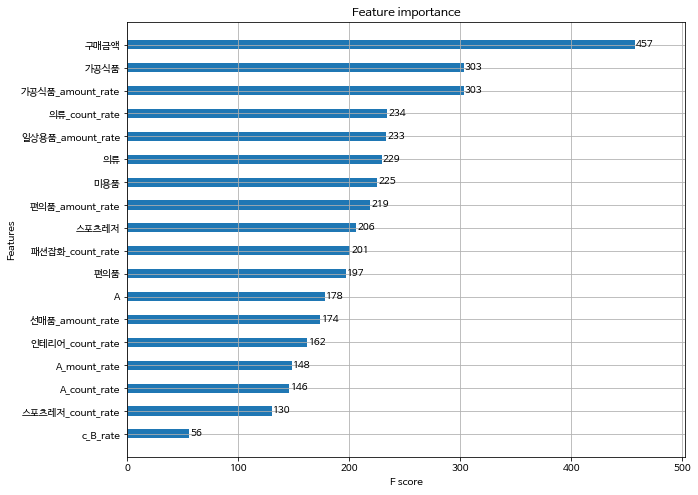

In [ ]:
# 변수 중요도
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

%matplotlib inline

xgb_clf = XGBClassifier(learning_rate=0.05, max_depth=4, n_estimators=300)
xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_test)
print('정확도 : %.2f' % accuracy_score(y_test, xgb_pred))

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

# <font color='red'>__데이터 전처리__</font>

In [ ]:
target_data = dataset1.query('y==1').drop('y',axis=1) # 구매감소고객

In [ ]:
# 차원축소 - 필요시 수정해서 사용
# from sklearn.decomposition import PCA

# pca = PCA(n_components=2)
# pca_transformed = pca.fit_transform(target_data)

In [ ]:
# 최소최대 정규화
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(target_data)
data_scaled = pd.DataFrame(data_scaled, columns=target_data.columns)

# <font color='red'>__elbow method__</font>  
  
#### 최적 군집 개수 찾기

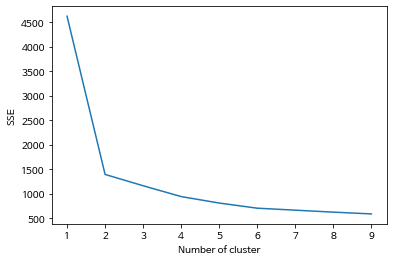

In [ ]:
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data_scaled)
    data_scaled["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()


In [ ]:
data_scaled.drop('clusters', axis=1, inplace=True)

# <font color=red>__군집분석__</font>

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import numpy as np

kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=100, random_state=0).fit(data_scaled)
data_scaled['cluster'] = kmeans.labels_

In [ ]:
data_scaled.cluster.value_counts()

0    3523
2    3098
1    1464
Name: cluster, dtype: int64

In [ ]:
# 모든 개별 데이터의 실루엣 계수값 
score_samples = silhouette_samples(data_scaled.drop('cluster',axis=1), data_scaled['cluster'])
print('silhouette_samples() return 값의 shape' , score_samples.shape)

# 실루엣 계수 컬럼 추가
data_scaled['silhouette_coeff'] = score_samples

# 모든 데이터의 평균 실루엣 계수값 
average_score = silhouette_score(data_scaled.drop('cluster',axis=1), data_scaled['cluster'])
print('Silhouette Analysis Score:{0:.3f}'.format(average_score))
data_scaled.head(3)

data_scaled.groupby('cluster')['silhouette_coeff'].mean()

silhouette_samples( ) return 값의 shape (8085,)
Silhouette Analysis Score:0.425


,c_B_rate,선매품_amount_rate,편의품_amount_rate,스포츠레저_count_rate,패션잡화_count_rate,의류_count_rate,인테리어_count_rate,가공식품_amount_rate,일상용품_amount_rate,A_count_rate,A_mount_rate,편의품,가공식품,미용품,스포츠레저,의류,A,구매금액,cluster,silhouette_coeff
0,0.2963,0.729026,0.270974,0.019435,0.081333,0.192195,0.060181,0.1071,0.090104,0.8485,0.9815,0.052503,0.011832,0.001364,0.000000,0.002243,0.002498,0.220092,0,0.541523
1,0.0000,0.056666,0.943334,0.000000,0.000000,0.001858,0.000000,0.5894,0.065365,0.0014,0.0422,0.061449,0.024887,0.001608,0.003314,0.000000,0.000000,0.157264,2,0.636057
2,0.0000,0.627851,0.372149,0.013073,0.067833,0.153172,0.031052,0.1963,0.035532,0.6923,0.8968,0.043336,0.013233,0.012141,0.014437,0.001156,0.001184,0.108232,0,0.490555


# 시각화

In [ ]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [ ]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화 
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
        
       # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

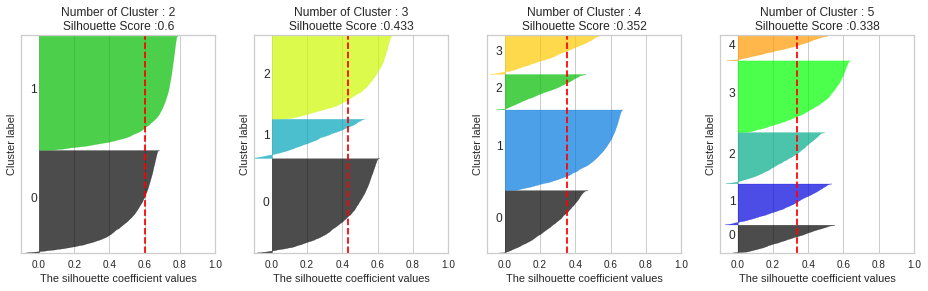

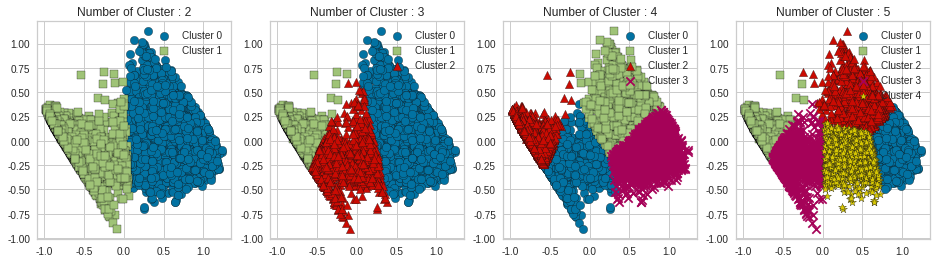

In [ ]:
# cluster 개수를 2개, 3개, 4개, 5개 일때의 클러스터별 실루엣 계수 평균값을 시각화 
visualize_silhouette([2, 3, 4, 5], data_scaled[data_scaled.columns[:-2]])
visualize_kmeans_plot_multi([2, 3, 4, 5],data_scaled[data_scaled.columns[:-2]])

In [ ]:
data_scaled = data_scaled[data_scaled.columns[:-2]]

# 3개로 군집

In [ ]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=1000, random_state=0).fit(data_scaled)
data_scaled['cluster'] = kmeans.labels_

# <font color='red'>__tree__</font>

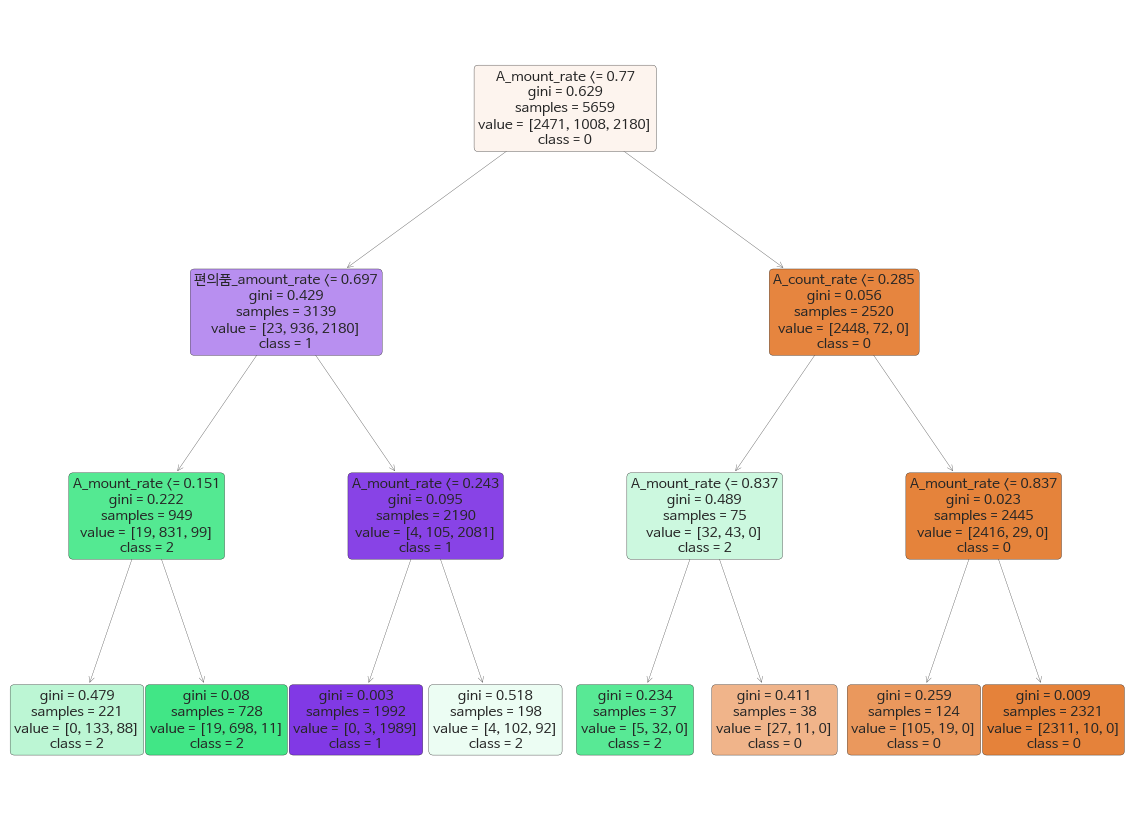

In [ ]:
# 감소고객만 - cluster 3개
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='NanumBarunGothic')


X_train, X_test, y_train, y_test = train_test_split(data_scaled.drop('cluster',axis=1),data_scaled.cluster,
                                                    test_size = 0.3,
                                                    random_state=1004)

dct_clf = DecisionTreeClassifier(max_depth=3)
dct_clf.fit(X_train,y_train)


plt.figure(figsize=(20,15))
plot_tree(dct_clf, filled=True,
              feature_names=X_train.columns,
              class_names=['0','2','1'],
              rounded=True, fontsize=14)# rounded : 박스의 모서리 처리
plt.show()

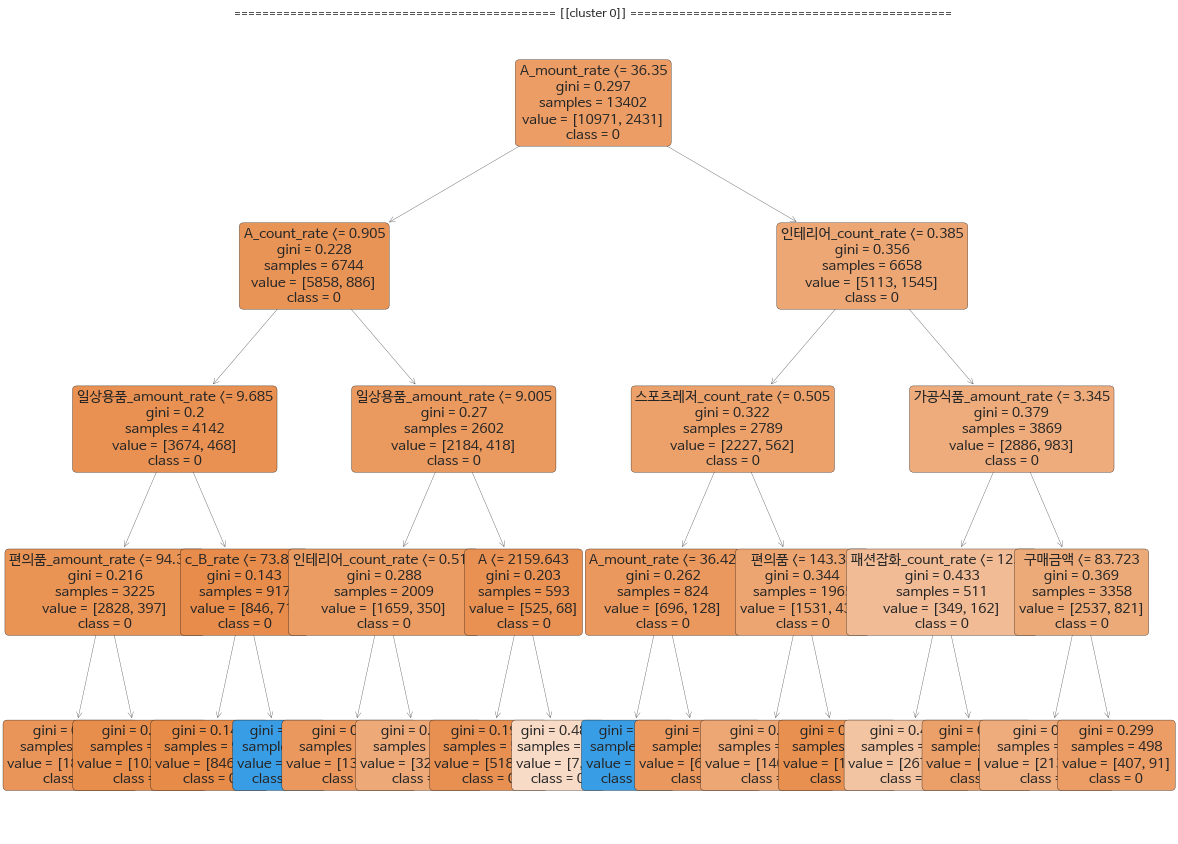

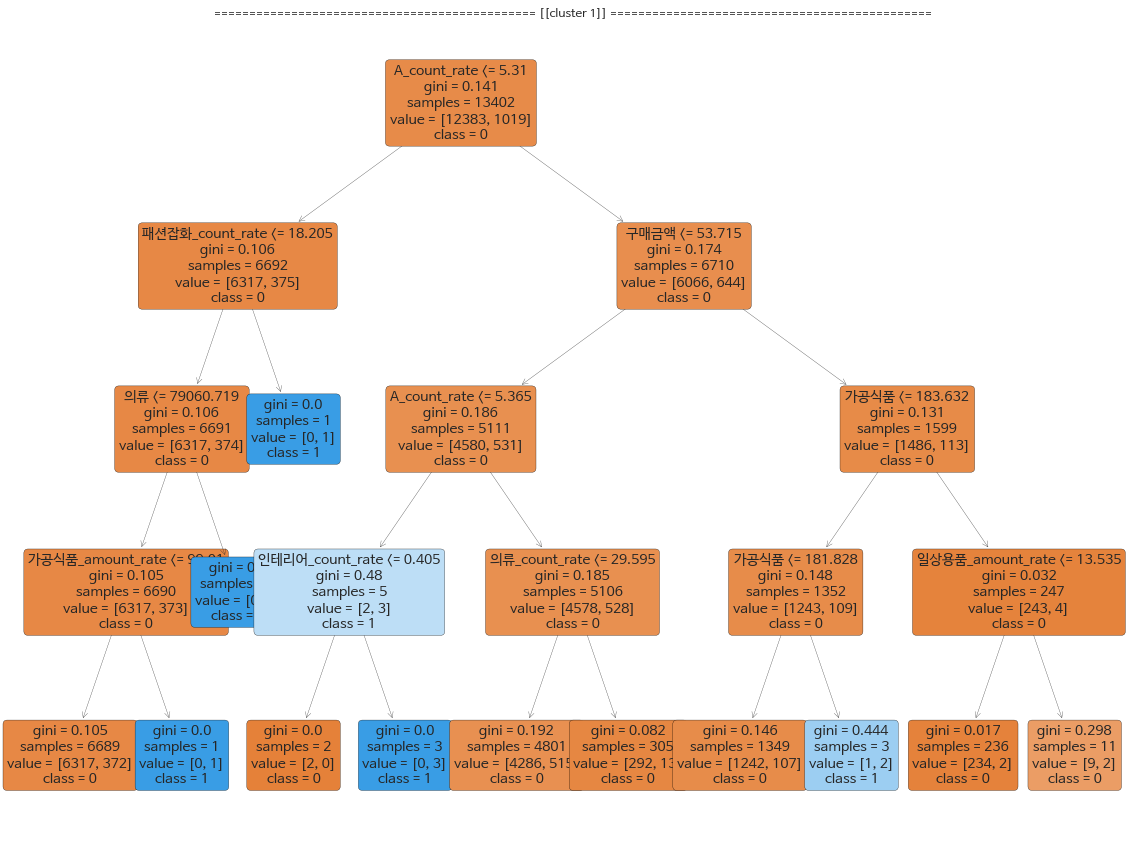

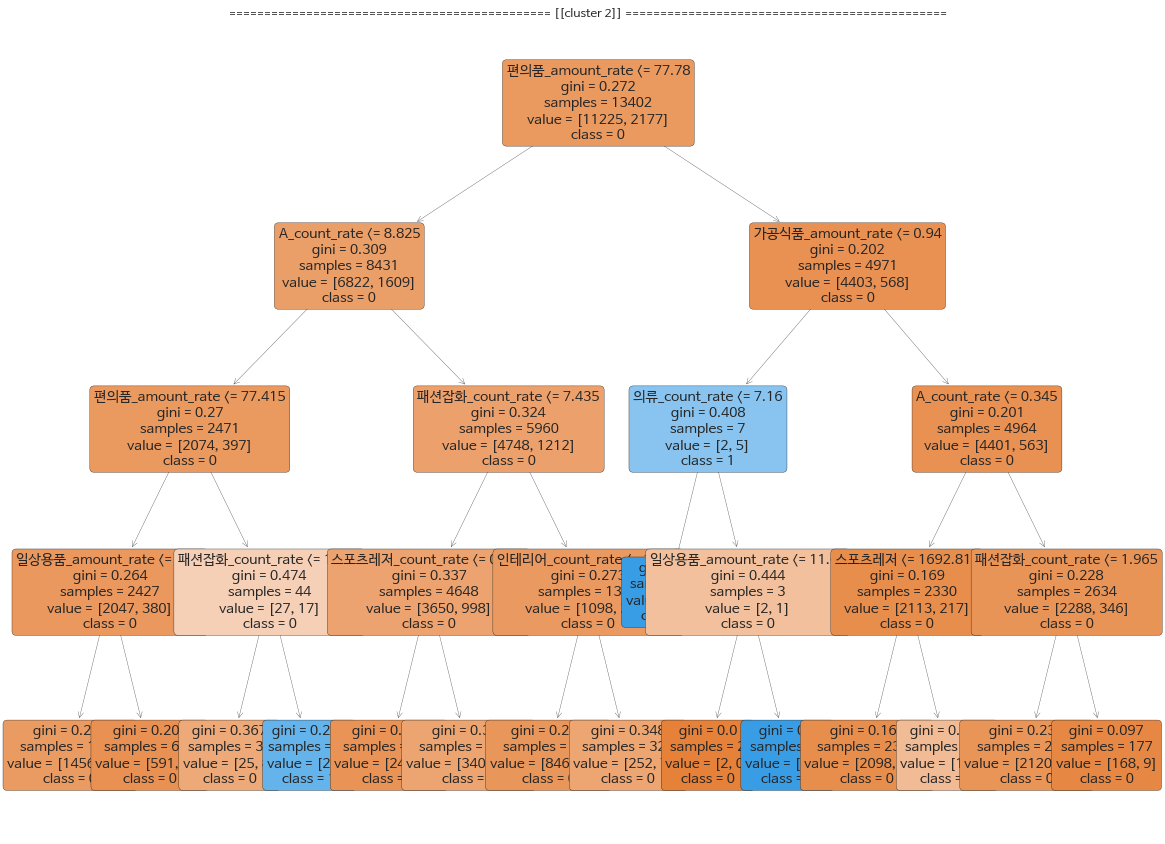

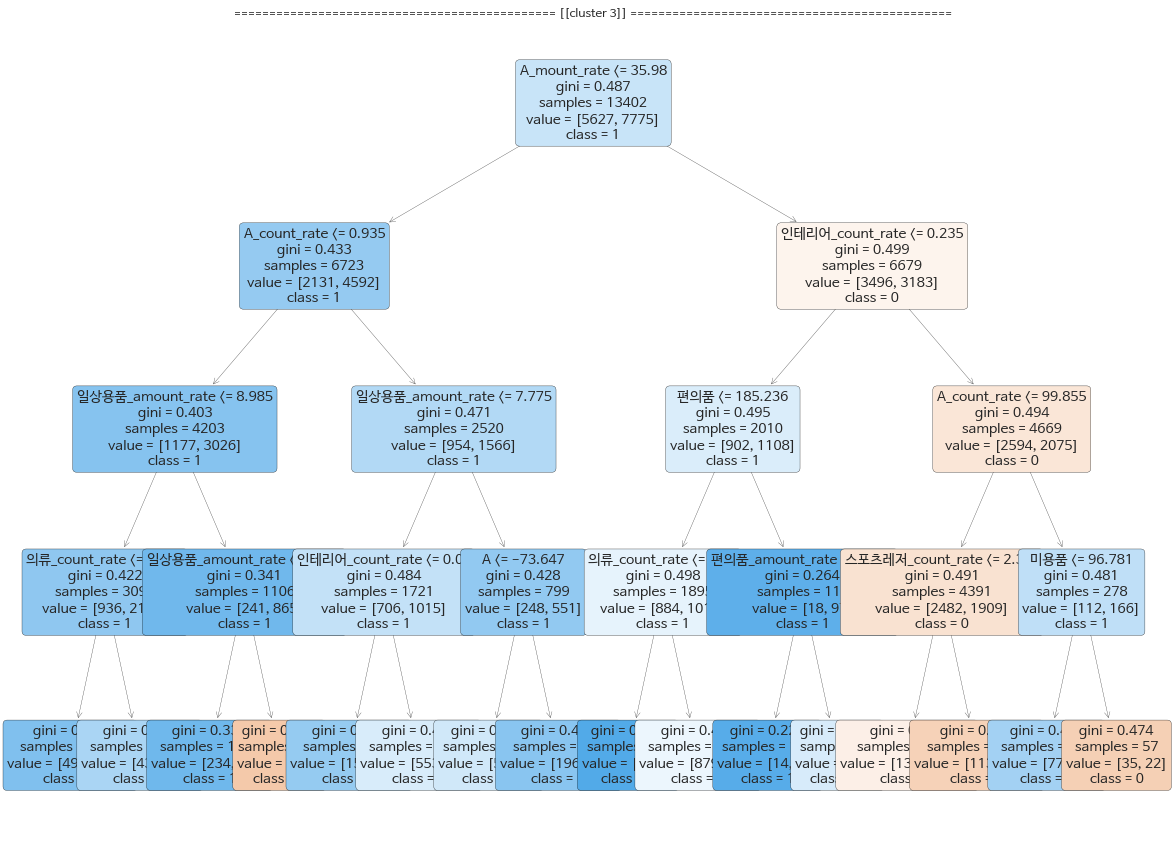

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
# 군집별 데이터셋 생성(전체 데이터셋, 감소 + 유지/증가 고객)
# tree_cluster 컬럼 - 해당 군집은 1, 나머지는 0
cluster_dataset = dataset1.join(data_scaled['cluster']).fillna(3)

def cluster_col(cluster, num):
    if cluster == num:
      return 1
    else:
      return 0

for num in range(4):
  globals()[f'cluster_{num}'] = cluster_dataset.copy()
  globals()[f'cluster_{num}']['tree_cluster'] = globals()[f'cluster_{num}'].apply(lambda x: cluster_col(x['cluster'],num), axis=1)
  globals()[f'cluster_{num}'].drop(['y','cluster'], axis=1, inplace=True)

  X_train, X_test, y_train, y_test = train_test_split(globals()[f'cluster_{num}'].drop(['tree_cluster'],axis=1),
                                                    globals()[f'cluster_{num}'].tree_cluster,
                                                    test_size = 0.3,
                                                    random_state=1004)

  dct_clf = DecisionTreeClassifier(max_depth=4)
  dct_clf.fit(X_train,y_train)


  plt.figure(figsize=(20,15))
  plot_tree(dct_clf, filled=True,
                feature_names=X_train.columns,
                class_names=['0','1','2','3'],
                rounded=True, fontsize=14)
  plt.title(f'============================================== [[cluster {num}]] ==============================================')
  # plt.show()

# 2개로 군집

In [ ]:
data_scaled.drop('cluster', axis=1, inplace=True)

In [ ]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=1000, random_state=0).fit(data_scaled)
data_scaled['cluster'] = kmeans.labels_

# <font color='red'>__tree__</font>

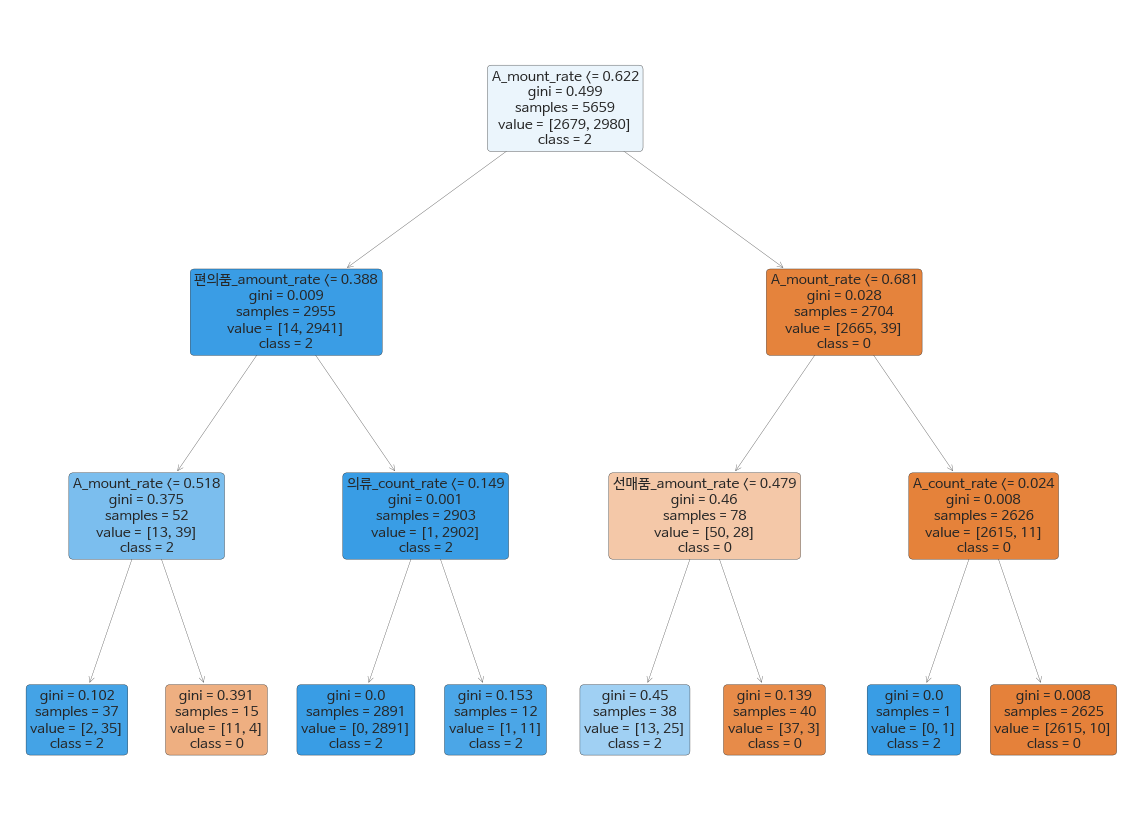

In [ ]:
# 감소고객만 - cluster 2개
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='NanumBarunGothic')


X_train, X_test, y_train, y_test = train_test_split(data_scaled.drop('cluster',axis=1),data_scaled.cluster,
                                                    test_size = 0.3,
                                                    random_state=1004)

dct_clf = DecisionTreeClassifier(max_depth=3)
dct_clf.fit(X_train,y_train)


plt.figure(figsize=(20,15))
plot_tree(dct_clf, filled=True,
              feature_names=X_train.columns,
              class_names=['0','2','1'],
              rounded=True, fontsize=14)# rounded : 박스의 모서리 처리
plt.show()

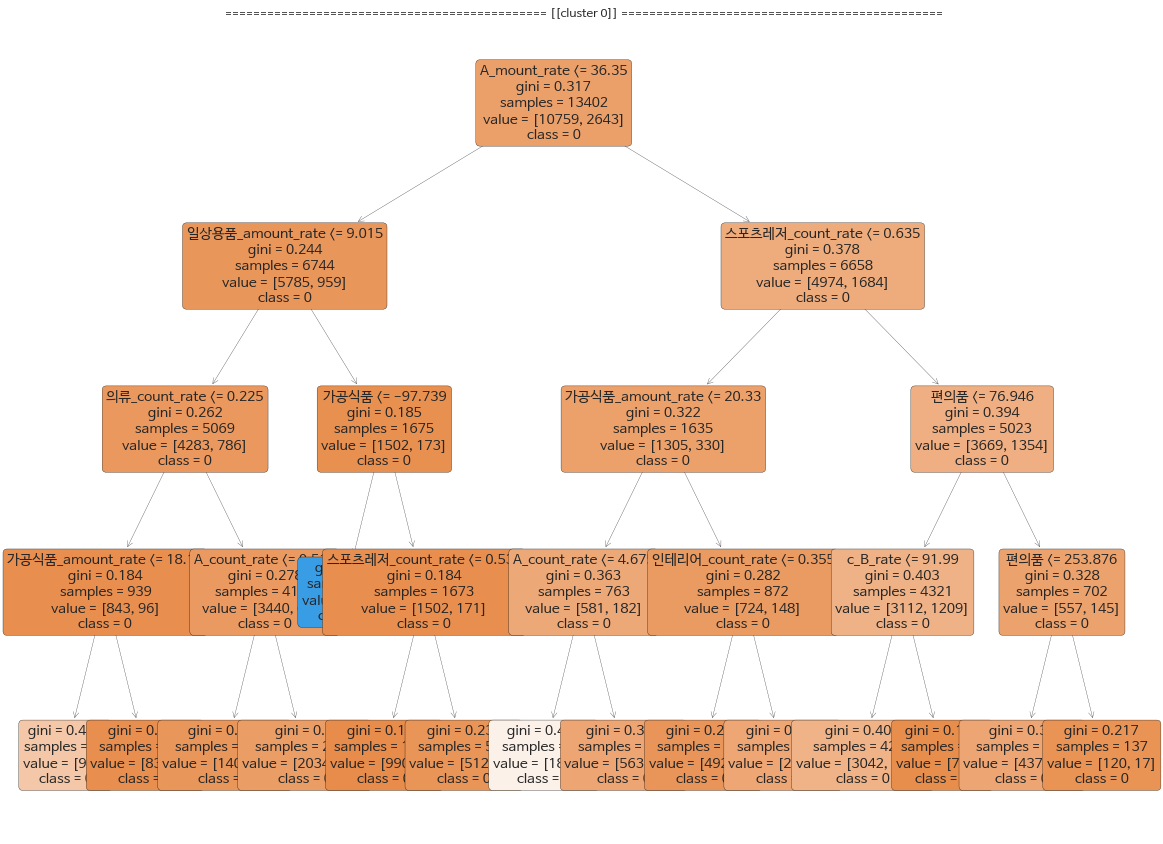

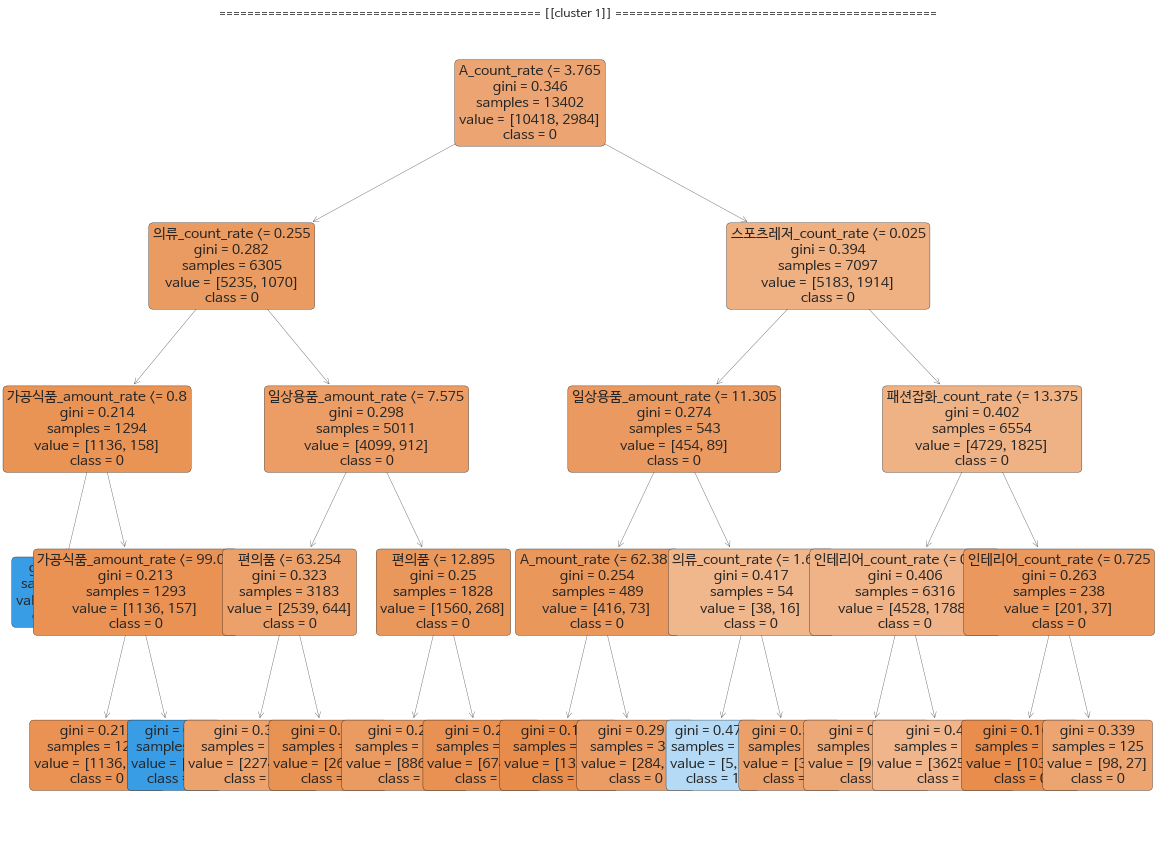

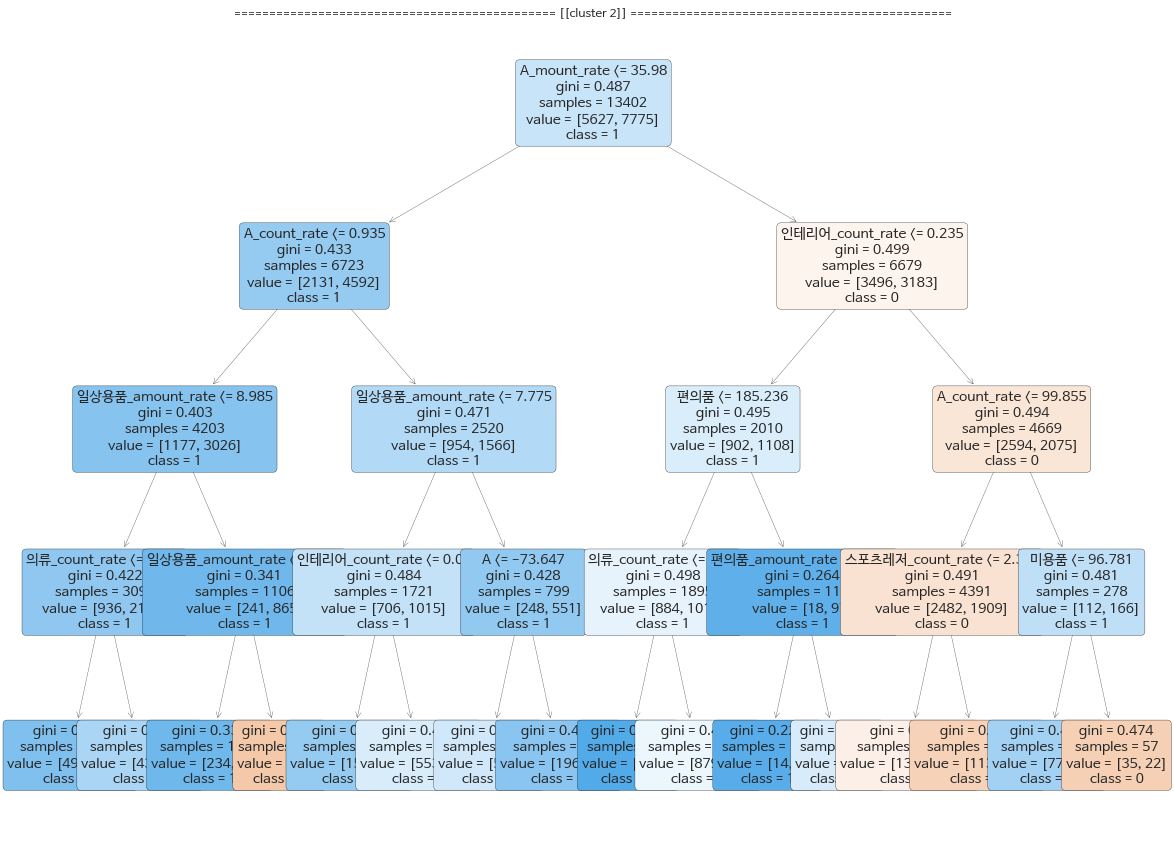

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
# 군집별 데이터셋 생성(전체 데이터셋, 감소 + 유지/증가 고객)
# tree_cluster 컬럼 - 해당 군집은 1, 나머지는 0
cluster_dataset = dataset1.join(data_scaled['cluster']).fillna(2)

def cluster_col(cluster, num):
    if cluster == num:
      return 1
    else:
      return 0

for num in range(3):
  globals()[f'cluster_{num}'] = cluster_dataset.copy()
  globals()[f'cluster_{num}']['tree_cluster'] = globals()[f'cluster_{num}'].apply(lambda x: cluster_col(x['cluster'],num), axis=1)
  globals()[f'cluster_{num}'].drop(['y','cluster'], axis=1, inplace=True)

  X_train, X_test, y_train, y_test = train_test_split(globals()[f'cluster_{num}'].drop(['tree_cluster'],axis=1),
                                                    globals()[f'cluster_{num}'].tree_cluster,
                                                    test_size = 0.3,
                                                    random_state=1004)

  dct_clf = DecisionTreeClassifier(max_depth=4)
  dct_clf.fit(X_train,y_train)


  plt.figure(figsize=(20,15))
  plot_tree(dct_clf, filled=True,
                feature_names=X_train.columns,
                class_names=['0','1','2','3'],
                rounded=True, fontsize=14)
  plt.title(f'============================================== [[cluster {num}]] ==============================================')
  # plt.show()